In [278]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import random                                #random song recommandation
from Levenshtein import ratio               # similarity ratio
from config import client_id, client_secret
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import pprint
from IPython.display import IFrame
import pickle

<h2> Dataframe Top_100 </h2>

In [3]:
# 1. Get top 100 and create Dataframe with artists & titles

In [4]:
url = "https://www.billboard.com/charts/hot-100/"

response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print(f"Error: {response.status_code}")

In [124]:
#artists: soup.find_all("span", class_="c-label")

In [126]:
artists=[]
for a in soup.select("span.c-label.a-no-trucate"):
    artists.append(a.get_text(strip=True))

In [12]:
#titles
#soup.find_all(class_ = 'o-chart-results-list-row-container')                # find all containers

In [128]:
titles = []
for title in soup.find_all(class_ = 'o-chart-results-list-row-container'):     #above h3
   titles.append(title.h3.get_text(strip = True))

In [18]:
# create Dataframe 

df= pd.DataFrame({
    "Titles": titles,
    "Artists": artists})
df

,Titles,Artists
0,A Bar Song (Tipsy),Shaboozey
1,Die With A Smile,Lady Gaga & Bruno Mars
2,Birds Of A Feather,Billie Eilish
3,Espresso,Sabrina Carpenter
4,Lose Control,Teddy Swims
...,...,...
95,Prove It,21 Savage & Summer Walker
96,4x4xU,Lainey Wilson
97,I Ain't Sayin',Jordan Davis
98,The Largest,BigXthaPlug


In [20]:
#df.to_csv("df_hot_100.csv", index=False)

In [22]:
# Create a Python program that takes a user input, checks if it is present in your scraped DataFrame

In [24]:
print("You can type 'exit' at any time to quit.")
while True:
    user_input = input("Please enter a song: ").strip()
    # Exit Condition!
    if user_input.lower() == "exit":
        print("Goodbye!")
        break
    if user_input in df["Titles"].values:
        random_song = df.sample(1)["Titles"].iloc[0]                                  #randomly one row
        print(f"Your song is popular! Here's another suggestion: '{random_song}'")
    else:
        print("Sorry, your song is not hot enough.")

You can type 'exit' at any time to quit.


Please enter a song:  exit


Goodbye!


In [ ]:
# Handling Typos
#!pip install python-Levenshtein
"""The Levenshtein algorithm measures how many operations (insertion, deletion, or substitution) are required to transform one string into another.
The result is a similarity score ranging from 0 (no similarity) to 1 (identical). If the similarity of a title exceeds the current best_score, that title is stored as the new best_match."""

In [22]:
print("You can type 'exit' at any time to quit.")
while True:
    user_input = input("Please enter a song: ").strip()
    if user_input.lower() == "exit":
        print("Goodbye!")
        break
                                                                # Levenshtein
    best_match = None
    best_score = 0
    
    for title in df["Titles"]:
        similarity = ratio(user_input, title)       # calculates similarity between 0 and 1
        if similarity > best_score:
            best_score = similarity
            best_match = title

    # check if similarity is high enough 
    if best_score >= 0.99:
        random_song = df.sample(1)["Titles"].iloc[0]
        print(f"It's hot! Here's is another suggestion: '{random_song}'")
    elif best_score >= 0.70:                                     # similarity treshhold: 60 % ?
        random_song = df.sample(1)["Titles"].iloc[0]  
        print(f"Did you mean '{best_match}'? It's in the list! Here's another suggestion: '{random_song}'")
    else:
        print("Sorry, your song is not hot enough.")

You can type 'exit' at any time to quit.


Please enter a song:  espreso


Did you mean 'Espresso'? It's in the list! Here's another suggestion: 'For Me'


Please enter a song:  exit


Goodbye!


In [ ]:
# Embedded track player 

In [26]:
def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [28]:
def get_spotify_id(title, artist):
    query = f"track:{title} artist:{artist}"
    result = sp.search(query, type="track", limit=1)
    if result['tracks']['items']:
        return result['tracks']['items'][0]['id']  # Track-ID
    else:
        return None  

In [370]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret), requests_timeout=10)

In [32]:
print("You can type 'exit' at any time to quit.")
while True:
    user_input = input("Please enter a song: ").strip()
    if user_input.lower() == "exit":
        print("Goodbye!")
        break

    best_match = None
    best_score = 0
    best_artist = None

    for index, row in df.iterrows():
        title = row["Titles"]
        artist = row["Artists"]
        similarity = ratio(user_input.lower(), title.lower())  # Berechnet die Ähnlichkeit
        if similarity > best_score:
            best_score = similarity
            best_match = title
            best_artist = artist

  
    if best_score >= 0.99: 
        track_id = get_spotify_id(best_match, best_artist)
        if track_id:
            print(f"Playing '{best_match}' by {best_artist}!")
            display(play_song(track_id))
        else:
            print(f"Sorry, no Spotify link found for '{best_match}'.")
    elif best_score >= 0.7:
        random_row = df.sample(1).iloc[0]
        random_song = random_row["Titles"]
        random_artist = random_row["Artists"]
        track_id = get_spotify_id(random_song, random_artist)
        if track_id:
            print(f"Did you mean '{best_match}'? Here's another suggestion: '{random_song}' by {random_artist}. Playing it now!")
            display(play_song(track_id))
        else:
            print(f"Sorry, no Spotify link found for '{best_match}'.")
    else:
        print("Sorry, your song is not hot enough.")

You can type 'exit' at any time to quit.


Please enter a song:  espreso


Sorry, no Spotify link found for 'Espresso'.


Please enter a song:  Birds Of A Feather


Playing 'Birds Of A Feather' by Billie Eilish!


Please enter a song:  bird of 


Sorry, your song is not hot enough.


Please enter a song:  espreso


Did you mean 'Espresso'? Here's another suggestion: 'Who' by Jimin. Playing it now!


Please enter a song:  exit


Goodbye!


<h2> Dataframe Audio_features </h2>

In [ ]:
# Using the Spotipy library, create a DataFrame storing the audio_features of at least 1000 songs.

In [ ]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

In [42]:
# pprint.pprint(results)

In [ ]:
# MOST POPULAR GENRES https://blog.novecore.com/top-10-most-popular-music-genres/

In [46]:
# Define get playlist function

def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id,market="GB")
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [48]:
# 1. POP

In [52]:
pop_playlist_tracks = get_playlist_tracks("Spotify","6mtYuOxzl58vSGnEDtZ9uB")
pop_ids = []
for i in pop_playlist_tracks:
    pop_ids.append(i['track']['id'])
    chunk_size = 100
pop_ids_chopped = [pop_ids[i:i+chunk_size] for i in range(0,len(pop_ids), 100)]

In [ ]:
pop_af = []
for i in pop_ids_chopped:
    pop_af.extend(sp.audio_features(i))
pd.DataFrame(pop_af)
pop_af = pd.DataFrame(pop_af)
#pop_af.to_csv("pop.csv", index=False) 

In [ ]:
# 2. ROCK 

In [ ]:
rock_playlist_tracks = get_playlist_tracks("Spotify","3sTZTkIGgm8wJiSXDvpApF")
rock_ids = []
for i in rock_playlist_tracks:
    rock_ids.append(i['track']['id'])
    chunk_size = 100
rock_ids_chopped = [rock_ids[i:i+chunk_size] for i in range(0,len(rock_ids), 100)]
rock_af = []
for i in rock_ids_chopped:
    rock_af.extend(sp.audio_features(i))
pd.DataFrame(rock_af).head(3)

In [ ]:
# 3. HipHop

In [ ]:
hop_playlist_tracks = get_playlist_tracks("Spotify","56un2laj6rmMUKhDlkUkAY")
hop_ids = []
for i in hop_playlist_tracks:
    hop_ids.append(i['track']['id'])

In [ ]:
chunk_size = 100
hop_ids_chopped = [hop_ids[i:i+chunk_size] for i in range(0,len(hop_ids), 100)]
hop_af = []
for i in hop_ids_chopped:
    hop_af.extend(sp.audio_features(i))
pd.DataFrame(hop_af).head(3)
hop_af = pd.DataFrame(hop_af)
#hop_af.to_csv("hop.csv", index=False) 

In [ ]:
# 4. R&B 

In [ ]:
rb_playlist_tracks = get_playlist_tracks("Spotify","3a9yodm1vqcU6JULLBeZeA")
rb_ids = []
for i in rb_playlist_tracks:
    rb_ids.append(i['track']['id'])
chunk_size = 100
rb_ids_chopped = [rb_ids[i:i+chunk_size] for i in range(0,len(hop_ids), 100)]
rb_af = []
for i in rb_ids_chopped:
    rb_af.extend(sp.audio_features(i))
pd.DataFrame(rb_af).head(3)
rb_af = pd.DataFrame(rb_af)
#rb_af.to_csv("rb.csv", index=False) 

In [ ]:
# 5. EDM

In [ ]:
edm_playlist_tracks = get_playlist_tracks("Spotify","1lS6v9h4MXOw6f6y8MkS8w")
edm_ids = []
for i in edm_playlist_tracks:
    edm_ids.append(i['track']['id'])
    edm_af = []
for i in edm_ids:
    edm_af.extend(sp.audio_features(i))
pd.DataFrame(edm_af).head(3)
edm_af = pd.DataFrame(edm_af)
#edm_af.to_csv("edm.csv", index=False) 

In [ ]:
# 6. Country 

In [ ]:
cn_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DWZBCPUIUs2iR")
cn_ids = []
for i in cn_playlist_tracks:
    cn_ids.append(i['track']['id'])
    cn_af = []
for i in cn_ids:
    cn_af.extend(sp.audio_features(i))
pd.DataFrame(cn_af).head(3)
cn_af = pd.DataFrame(cn_af)
#cn_af.to_csv("cn.csv", index=False) 

In [ ]:
# 7. Jazz 

In [ ]:
jz_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DXbITWG1ZJKYt")
jz_ids = []
for i in jz_playlist_tracks:
    jz_ids.append(i['track']['id'])
    chunk_size = 100
jz_ids_chopped = [jz_ids[i:i+chunk_size] for i in range(0,len(jz_ids), 100)]
jz_af = []
for i in jz_ids_chopped:
    jz_af.extend(sp.audio_features(i))
pd.DataFrame(jz_af).head(3)
jz_af = pd.DataFrame(jz_af)
#jz_af.to_csv("jz.csv", index=False) 

In [ ]:
# 8. Raeggae 

In [ ]:
rg_playlist_tracks = get_playlist_tracks("Spotify","0uKEs5Je7unyIpYlK9d320")
rg_ids = []
for i in rg_playlist_tracks:
    rg_ids.append(i['track']['id'])
chunk_size = 100
rg_ids_chopped = [rg_ids[i:i+chunk_size] for i in range(0,len(rg_ids), 100)]
rg_af = []
for i in rg_ids_chopped:
    rg_af.extend(sp.audio_features(i))
pd.DataFrame(rg_af).head(3)
rg_af = pd.DataFrame(rg_af)
#rg_af.to_csv("rg.csv", index=False) 

In [ ]:
# 9. Latin

In [ ]:
ln_playlist_tracks = get_playlist_tracks("Spotify","47lKGlxoijn8lJyWcNBwEW")
ln_ids = []
for i in ln_playlist_tracks:
    ln_ids.append(i['track']['id'])
ln_af = []
for i in ln_ids:
    ln_af.extend(sp.audio_features(i))
pd.DataFrame(ln_af).head(3)
ln_af = pd.DataFrame(ln_af)
#ln_af.to_csv("ln.csv", index=False) 

In [ ]:
# 10. Classical 

In [ ]:
cl_playlist_tracks = get_playlist_tracks("Spotify","1DSEi0lvLOzTiKqnaYZBDh")
cl_ids = []
for i in cl_playlist_tracks:
    cl_ids.append(i['track']['id'])
    cl_af = []
for i in cl_ids:
    cl_af.extend(sp.audio_features(i))
pd.DataFrame(cl_af).head(3)
cl_af = pd.DataFrame(cl_af)
#cl_af.to_csv("cl.csv", index=False) 

In [ ]:
# 11. Techno

In [ ]:
tn_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DX6J5NfMJS675")
tn_ids = []
for i in tn_playlist_tracks:
    tn_ids.append(i['track']['id'])
    chunk_size = 100
tn_ids_chopped = [tn_ids[i:i+chunk_size] for i in range(0,len(tn_ids), 100)]
tn_af = []
for i in tn_ids_chopped:
    tn_af.extend(sp.audio_features(i))
pd.DataFrame(tn_af).head(3)
tn_af = pd.DataFrame(tn_af)
#tn_af.to_csv("tn.csv", index=False) 

In [ ]:
# 12. Deutschrap

In [ ]:
dr_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DWSzguhfGl55y")
dr_ids = []
for i in dr_playlist_tracks:
    dr_ids.append(i['track']['id'])
dr_af = []
for i in dr_ids:
    dr_af.extend(sp.audio_features(i))
pd.DataFrame(dr_af).head(3)
dr_af = pd.DataFrame(dr_af)
#dr_af.to_csv("dr.csv", index=False) 

In [ ]:
# 13. Metal

In [ ]:
mt_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1EQpgT26jgbgRI")
mt_ids = []
for i in mt_playlist_tracks:
    mt_ids.append(i['track']['id'])
    mt_af = []
for i in mt_ids:
    mt_af.extend(sp.audio_features(i))
pd.DataFrame(mt_af).head(3)
mt_af = pd.DataFrame(mt_af)
#mt_af.to_csv("mt.csv", index=False) 

In [ ]:
# 14. Indie

In [ ]:
ind_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DWYJeWl6ior4d")
ind_ids = []
for i in ind_playlist_tracks:
    ind_ids.append(i['track']['id'])
    ind_af = []
for i in ind_ids:
    ind_af.extend(sp.audio_features(i))
pd.DataFrame(ind_af).head(3)
ind_af = pd.DataFrame(ind_af)
#ind_af.to_csv("ind.csv", index=False) 

In [ ]:
# 15 Downtempo

In [ ]:
dt_playlist_tracks = get_playlist_tracks("Spotify","57uN4exPbSwPc4K3Fwx1vw")
dt_ids = []
for i in dt_playlist_tracks:
    dt_ids.append(i['track']['id'])
    chunk_size = 100
dt_ids_chopped = [dt_ids[i:i+chunk_size] for i in range(0,len(dt_ids), 100)]
dt_af = []
for i in dt_ids_chopped:
    dt_af.extend(sp.audio_features(i))
pd.DataFrame(dt_af).head(3)
dt_af = pd.DataFrame(dt_af)
#dt_af.to_csv("dt.csv", index=False) 

In [ ]:
# 16 Soundtracks

In [ ]:
st_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DX8C9xQcOrE6T")
st_ids = []
for i in st_playlist_tracks:
    st_ids.append(i['track']['id'])
chunk_size = 100
st_ids_chopped = [st_ids[i:i+chunk_size] for i in range(0,len(st_ids), 100)]
st_af = []
for i in st_ids_chopped:
    st_af.extend(sp.audio_features(i))
pd.DataFrame(st_af).head(3)
st_af = pd.DataFrame(st_af)
#st_af.to_csv("st.csv", index=False) 

In [ ]:
# 17. mixed playlist 

In [ ]:
mx_playlist_tracks = get_playlist_tracks("Spotify","3ARGWPi5zf8sfl86RhG1UB")
mx_ids = []
for i in mx_playlist_tracks:
    mx_ids.append(i['track']['id'])
chunk_size = 100
mx_ids_chopped = [mx_ids[i:i+chunk_size] for i in range(0,len(mx_ids), 100)]
mx_af = []
for i in mx_ids_chopped:
    mx_af.extend(sp.audio_features(i))
pd.DataFrame(mx_af).head(3)
mx_af = pd.DataFrame(mx_af)
#mx_af.to_csv("mx.csv", index=False) 

In [ ]:
# 18. Oldies

In [ ]:
old_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DX56bqlsMxJYR")
old_ids = []
for i in old_playlist_tracks:
    old_ids.append(i['track']['id'])
chunk_size = 100
old_ids_chopped = [old_ids[i:i+chunk_size] for i in range(0,len(old_ids), 100)]
old_af = []
for i in old_ids_chopped:
    old_af.extend(sp.audio_features(i))
pd.DataFrame(old_af).head(3)
old_af = pd.DataFrame(old_af)
#old_af.to_csv("old.csv", index=False) 

In [ ]:
# 19. New

In [ ]:
new_playlist_tracks = get_playlist_tracks("Spotify","37i9dQZF1DX4JAvHpjipBk")
new_ids = []
for i in new_playlist_tracks:
    new_ids.append(i['track']['id'])
new_af = []
for i in new_ids:
    new_af.extend(sp.audio_features(i))
pd.DataFrame(new_af).head(3)
new_af = pd.DataFrame(new_af)
#new_af.to_csv("new.csv", index=False) 

In [ ]:
# 20. Mixed2024

In [ ]:
m2_playlist_tracks = get_playlist_tracks("Spotify","2DpRAKsc8kVq3GaZ9LKaoC")
m2_ids = []
for i in m2_playlist_tracks:
    m2_ids.append(i['track']['id'])
chunk_size = 100
m2_ids_chopped = [m2_ids[i:i+chunk_size] for i in range(0,len(m2_ids), 100)]
m2_af = []
for i in m2_ids_chopped:
    m2_af.extend(sp.audio_features(i))
pd.DataFrame(m2_af).head(3)
m2_af = pd.DataFrame(m2_af)
#m2_af.to_csv("m2.csv", index=False) 

In [ ]:
# Combine Dataframes

In [ ]:
dataframes = [pop_af, rock_af, hop_af, rb_af, edm_af, cn_af, jz_af, rg_af, ln_af, cl_af, tn_af, dr_af, mt_af, ind_af, dt_af, st_af, mx_af, old_af, new_af, m2_af]
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df

In [ ]:
#combined_df.duplicated().sum()
#combined_df = combined_df.drop_duplicates()

In [ ]:
#combined_df.to_csv("combined_df.csv", index=False) 

In [58]:
combined_df.columns    #https://developer.spotify.com/documentation/web-api/reference/get-audio-features 

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [44]:
file_path='/Users/ironhack/Documents/GitHub/Song-Recommandation/combined_df.csv'
combined_df = pd.read_csv(file_path)
combined_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.623,0.734,9,-5.948,1,0.1070,0.01620,0.000002,0.1450,0.370,107.853,audio_features,76FZM38RC8XaAjJ77CVTNe,spotify:track:76FZM38RC8XaAjJ77CVTNe,https://api.spotify.com/v1/tracks/76FZM38RC8Xa...,https://api.spotify.com/v1/audio-analysis/76FZ...,244453,4
1,0.722,0.851,7,-3.873,0,0.0639,0.03190,0.000000,0.1080,0.452,126.885,audio_features,5yDL13y5giogKs2fSNf7sj,spotify:track:5yDL13y5giogKs2fSNf7sj,https://api.spotify.com/v1/tracks/5yDL13y5giog...,https://api.spotify.com/v1/audio-analysis/5yDL...,197936,4
2,0.647,0.585,6,-6.123,1,0.0512,0.00314,0.000000,0.1650,0.353,131.934,audio_features,5jrdCoLpJSvHHorevXBATy,spotify:track:5jrdCoLpJSvHHorevXBATy,https://api.spotify.com/v1/tracks/5jrdCoLpJSvH...,https://api.spotify.com/v1/audio-analysis/5jrd...,215672,4
3,0.688,0.734,9,-4.569,1,0.0274,0.00462,0.000000,0.0756,0.460,140.004,audio_features,2hns6Dv29Yrg68AVTJiAyA,spotify:track:2hns6Dv29Yrg68AVTJiAyA,https://api.spotify.com/v1/tracks/2hns6Dv29Yrg...,https://api.spotify.com/v1/audio-analysis/2hns...,208493,4
4,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.661,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,0.393,0.714,11,-8.521,1,0.0374,0.15900,0.000002,0.3120,0.769,115.522,audio_features,0mwr3py9MZIOdvOrI31h6r,spotify:track:0mwr3py9MZIOdvOrI31h6r,https://api.spotify.com/v1/tracks/0mwr3py9MZIO...,https://api.spotify.com/v1/audio-analysis/0mwr...,166520,4
1870,0.552,0.313,5,-12.410,1,0.0296,0.91600,0.001700,0.1200,0.303,88.554,audio_features,3YdKJzcoMZMacISlpY4QoP,spotify:track:3YdKJzcoMZMacISlpY4QoP,https://api.spotify.com/v1/tracks/3YdKJzcoMZMa...,https://api.spotify.com/v1/audio-analysis/3YdK...,202773,3
1871,0.592,0.522,2,-9.922,0,0.2170,0.77700,0.000000,0.2190,0.808,150.452,audio_features,0QoV9nLBwYEU1bA6m61h4F,spotify:track:0QoV9nLBwYEU1bA6m61h4F,https://api.spotify.com/v1/tracks/0QoV9nLBwYEU...,https://api.spotify.com/v1/audio-analysis/0QoV...,149560,4
1872,0.431,0.643,10,-11.391,1,0.3860,0.78500,0.000000,0.3600,0.540,201.611,audio_features,4rc5ZzvU4Ke8Yy2A2wRaIl,spotify:track:4rc5ZzvU4Ke8Yy2A2wRaIl,https://api.spotify.com/v1/tracks/4rc5ZzvU4Ke8...,https://api.spotify.com/v1/audio-analysis/4rc5...,142453,4


In [46]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1874 non-null   float64
 1   energy            1874 non-null   float64
 2   key               1874 non-null   int64  
 3   loudness          1874 non-null   float64
 4   mode              1874 non-null   int64  
 5   speechiness       1874 non-null   float64
 6   acousticness      1874 non-null   float64
 7   instrumentalness  1874 non-null   float64
 8   liveness          1874 non-null   float64
 9   valence           1874 non-null   float64
 10  tempo             1874 non-null   float64
 11  type              1874 non-null   object 
 12  id                1874 non-null   object 
 13  uri               1874 non-null   object 
 14  track_href        1874 non-null   object 
 15  analysis_url      1874 non-null   object 
 16  duration_ms       1874 non-null   int64  


In [48]:
#combined_df.isnull().sum()

In [50]:
#features: danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, valence

In [52]:
# scaling values
from sklearn.preprocessing import StandardScaler

In [681]:
# scaling values

audio_features = ['danceability', 'energy', 'key','loudness', 
                  'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(combined_df[audio_features])
combined_df[audio_features] = df_scaled
combined_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,KMeans_Cluster
0,0.011468,0.447217,1.097076,0.528670,0.81686,0.212034,-0.854561,-0.455489,0.1450,-0.792495,-0.381255,audio_features,76FZM38RC8XaAjJ77CVTNe,spotify:track:76FZM38RC8XaAjJ77CVTNe,https://api.spotify.com/v1/tracks/76FZM38RC8Xa...,https://api.spotify.com/v1/audio-analysis/76FZ...,244453,4,4
1,0.608399,0.905214,0.537032,0.952037,-1.22420,-0.282999,-0.806791,-0.455496,0.1080,-0.470707,0.278579,audio_features,5yDL13y5giogKs2fSNf7sj,spotify:track:5yDL13y5giogKs2fSNf7sj,https://api.spotify.com/v1/tracks/5yDL13y5giog...,https://api.spotify.com/v1/audio-analysis/5yDL...,197936,4,2
2,0.156179,-0.136044,0.257010,0.492964,0.81686,-0.428868,-0.894298,-0.455496,0.1650,-0.859207,0.453626,audio_features,5jrdCoLpJSvHHorevXBATy,spotify:track:5jrdCoLpJSvHHorevXBATy,https://api.spotify.com/v1/tracks/5jrdCoLpJSvH...,https://api.spotify.com/v1/audio-analysis/5jrd...,215672,4,4
3,0.403393,0.447217,1.097076,0.810030,0.81686,-0.702227,-0.889795,-0.455496,0.0756,-0.439314,0.733411,audio_features,2hns6Dv29Yrg68AVTJiAyA,spotify:track:2hns6Dv29Yrg68AVTJiAyA,https://api.spotify.com/v1/tracks/2hns6Dv29Yrg...,https://api.spotify.com/v1/audio-analysis/2hns...,208493,4,4
4,0.765169,-0.374829,0.817054,0.599877,0.81686,-0.628719,0.355813,-0.455496,0.1110,0.349458,-0.826518,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,-1.375341,0.368927,1.657119,0.003695,0.81686,-0.587370,-0.420067,-0.455487,0.3120,0.773276,-0.115373,audio_features,0mwr3py9MZIOdvOrI31h6r,spotify:track:0mwr3py9MZIOdvOrI31h6r,https://api.spotify.com/v1/tracks/0mwr3py9MZIO...,https://api.spotify.com/v1/audio-analysis/0mwr...,166520,4,4
1870,-0.416634,-1.200789,-0.023011,-0.789787,0.81686,-0.676959,1.883234,-0.449283,0.1200,-1.055419,-1.050346,audio_features,3YdKJzcoMZMacISlpY4QoP,spotify:track:3YdKJzcoMZMacISlpY4QoP,https://api.spotify.com/v1/tracks/3YdKJzcoMZMa...,https://api.spotify.com/v1/audio-analysis/3YdK...,202773,3,6
1871,-0.175450,-0.382658,-0.863077,-0.282154,-1.22420,1.475462,1.460303,-0.455496,0.2190,0.926321,1.095640,audio_features,0QoV9nLBwYEU1bA6m61h4F,spotify:track:0QoV9nLBwYEU1bA6m61h4F,https://api.spotify.com/v1/tracks/0QoV9nLBwYEU...,https://api.spotify.com/v1/audio-analysis/0QoV...,149560,4,5
1872,-1.146216,0.090997,1.377097,-0.581878,0.81686,3.416545,1.484644,-0.455496,0.3600,-0.125375,2.869307,audio_features,4rc5ZzvU4Ke8Yy2A2wRaIl,spotify:track:4rc5ZzvU4Ke8Yy2A2wRaIl,https://api.spotify.com/v1/tracks/4rc5ZzvU4Ke8...,https://api.spotify.com/v1/audio-analysis/4rc5...,142453,4,5


In [563]:
# save Scaler as Pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [565]:
df_scaled = pd.DataFrame(df_scaled, columns=audio_features)
df_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence
0,0.011468,0.447217,1.097076,0.528670,0.81686,0.212034,-0.854561,-0.455489,-0.792495
1,0.608399,0.905214,0.537032,0.952037,-1.22420,-0.282999,-0.806791,-0.455496,-0.470707
2,0.156179,-0.136044,0.257010,0.492964,0.81686,-0.428868,-0.894298,-0.455496,-0.859207
3,0.403393,0.447217,1.097076,0.810030,0.81686,-0.702227,-0.889795,-0.455496,-0.439314
4,0.765169,-0.374829,0.817054,0.599877,0.81686,-0.628719,0.355813,-0.455496,0.349458
...,...,...,...,...,...,...,...,...,...
1869,-1.375341,0.368927,1.657119,0.003695,0.81686,-0.587370,-0.420067,-0.455487,0.773276
1870,-0.416634,-1.200789,-0.023011,-0.789787,0.81686,-0.676959,1.883234,-0.449283,-1.055419
1871,-0.175450,-0.382658,-0.863077,-0.282154,-1.22420,1.475462,1.460303,-0.455496,0.926321
1872,-1.146216,0.090997,1.377097,-0.581878,0.81686,3.416545,1.484644,-0.455496,-0.125375


<h3> MODEL </h3>

In [567]:
# Kmeans

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [569]:
kmeans = KMeans(n_clusters=7, random_state=42)
combined_df['KMeans_Cluster'] = kmeans.fit_predict(combined_df[['danceability', 'energy', 'key','loudness',
                  'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence']])

In [571]:
best_kmeans= kmeans
best_kmeans

KMeans(n_clusters=7, random_state=42)

In [573]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6}

In [575]:
combined_df.tail(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,KMeans_Cluster
1864,1.157094,-0.002951,0.537032,0.068577,0.81686,-0.679256,-0.158398,-0.400308,0.1130,0.792897,-0.148032,audio_features,7lL2lMWNtzOcf5HnEudNgn,spotify:track:7lL2lMWNtzOcf5HnEudNgn,https://api.spotify.com/v1/tracks/7lL2lMWNtzOc...,https://api.spotify.com/v1/audio-analysis/7lL2...,139507,4,4
1865,-0.060887,-1.725333,-0.303033,-1.517570,0.81686,-0.456433,1.889319,-0.455496,0.1090,-0.062587,0.493115,audio_features,4h0igWYayzteBtSNpWYQ9h,spotify:track:4h0igWYayzteBtSNpWYQ9h,https://api.spotify.com/v1/tracks/4h0igWYayzte...,https://api.spotify.com/v1/audio-analysis/4h0i...,138080,4,6
1866,-1.417549,-0.574469,-0.863077,-0.791011,0.81686,-0.620679,1.314254,-0.455496,0.2710,-0.290193,-0.295656,audio_features,622sVNQCspoVUqFWzOYYcj,spotify:track:622sVNQCspoVUqFWzOYYcj,https://api.spotify.com/v1/tracks/622sVNQCspoV...,https://api.spotify.com/v1/audio-analysis/622s...,205640,4,6
1867,-0.941210,-1.494377,-1.423120,-0.268280,0.81686,-0.704525,1.648948,-0.455426,0.1500,-0.337283,-0.635142,audio_features,2TqB6mGZ2BY9meVuJTqv5G,spotify:track:2TqB6mGZ2BY9meVuJTqv5G,https://api.spotify.com/v1/tracks/2TqB6mGZ2BY9...,https://api.spotify.com/v1/audio-analysis/2TqB...,135000,3,6
1868,0.903850,-0.382658,1.657119,-0.745512,0.81686,-0.594262,0.833513,-0.455496,0.1450,1.444320,0.339459,audio_features,7N15WWy12QAMpGAh6QMAej,spotify:track:7N15WWy12QAMpGAh6QMAej,https://api.spotify.com/v1/tracks/7N15WWy12QAM...,https://api.spotify.com/v1/audio-analysis/7N15...,129061,4,4
1869,-1.375341,0.368927,1.657119,0.003695,0.81686,-0.587370,-0.420067,-0.455487,0.3120,0.773276,-0.115373,audio_features,0mwr3py9MZIOdvOrI31h6r,spotify:track:0mwr3py9MZIOdvOrI31h6r,https://api.spotify.com/v1/tracks/0mwr3py9MZIO...,https://api.spotify.com/v1/audio-analysis/0mwr...,166520,4,4
1870,-0.416634,-1.200789,-0.023011,-0.789787,0.81686,-0.676959,1.883234,-0.449283,0.1200,-1.055419,-1.050346,audio_features,3YdKJzcoMZMacISlpY4QoP,spotify:track:3YdKJzcoMZMacISlpY4QoP,https://api.spotify.com/v1/tracks/3YdKJzcoMZMa...,https://api.spotify.com/v1/audio-analysis/3YdK...,202773,3,6
1871,-0.175450,-0.382658,-0.863077,-0.282154,-1.22420,1.475462,1.460303,-0.455496,0.2190,0.926321,1.095640,audio_features,0QoV9nLBwYEU1bA6m61h4F,spotify:track:0QoV9nLBwYEU1bA6m61h4F,https://api.spotify.com/v1/tracks/0QoV9nLBwYEU...,https://api.spotify.com/v1/audio-analysis/0QoV...,149560,4,5
1872,-1.146216,0.090997,1.377097,-0.581878,0.81686,3.416545,1.484644,-0.455496,0.3600,-0.125375,2.869307,audio_features,4rc5ZzvU4Ke8Yy2A2wRaIl,spotify:track:4rc5ZzvU4Ke8Yy2A2wRaIl,https://api.spotify.com/v1/tracks/4rc5ZzvU4Ke8...,https://api.spotify.com/v1/audio-analysis/4rc5...,142453,4,5
1873,-1.465786,0.243663,1.377097,-0.344588,0.81686,0.407291,-0.667436,-0.455485,0.0573,1.248109,2.302874,audio_features,2oezpnnea1VXHpJEbqnBhw,spotify:track:2oezpnnea1VXHpJEbqnBhw,https://api.spotify.com/v1/tracks/2oezpnnea1VX...,https://api.spotify.com/v1/audio-analysis/2oez...,166507,4,4


Training a K-Means model with 2 clusters!
Training a K-Means model with 3 clusters!
Training a K-Means model with 4 clusters!
Training a K-Means model with 5 clusters!
Training a K-Means model with 6 clusters!
Training a K-Means model with 7 clusters!
Training a K-Means model with 8 clusters!
Training a K-Means model with 9 clusters!
Training a K-Means model with 10 clusters!
Training a K-Means model with 11 clusters!
Training a K-Means model with 12 clusters!
Training a K-Means model with 13 clusters!
Training a K-Means model with 14 clusters!
Training a K-Means model with 15 clusters!
Training a K-Means model with 16 clusters!
Training a K-Means model with 17 clusters!
Training a K-Means model with 18 clusters!
Training a K-Means model with 19 clusters!


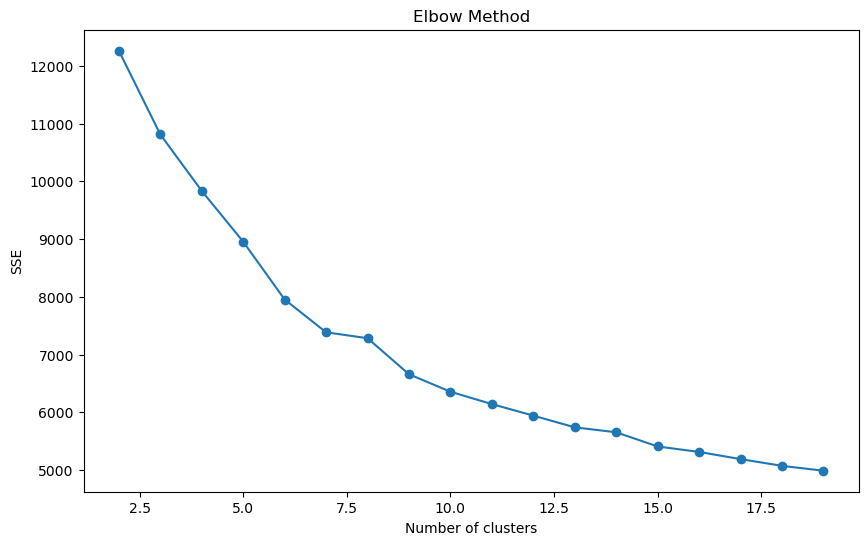

In [577]:
# Elbowmethod 
K = range(2, 20)  # Cluster-Bereich definieren
sse = []  # Hier speichern wir die Summe der quadratischen Fehler (SSE)

for k in K:
    print(f"Training a K-Means model with {k} clusters!")
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)  # Inertia = SSE

# Elbow Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(K, sse, marker='o')  # Verwende K und SSE
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

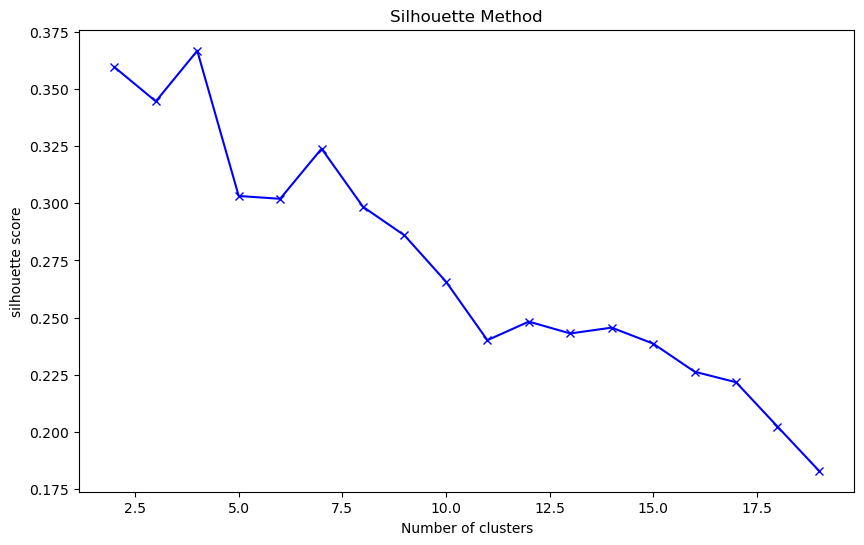

In [422]:
# Silhouette Method
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234, n_init='auto')
    kmeans.fit(df_scaled)
    silhouette.append(silhouette_score((df_scaled), kmeans.predict((df_scaled))))

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette, 'bx-')  # Verwende K und SSE
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

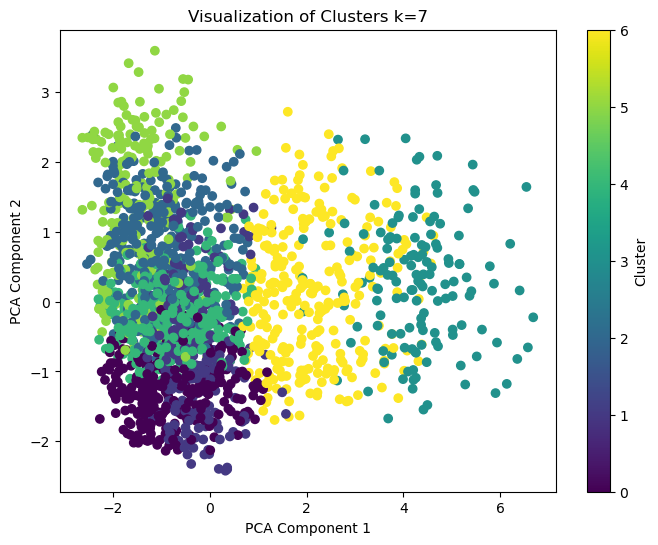

In [585]:
# Visualisation with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(df_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title(f'Visualization of Clusters k=7')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [587]:
best_kmeans

KMeans(n_clusters=7, random_state=42)

In [589]:
#save model as pickle

with open("best_kmeans.pickle", "wb") as f:
    pickle.dump(best_kmeans,f)

In [591]:
# load pickle

def load(filename = "best_kmeans.pickle"): 
    with open(filename, "rb") as f: 
        return pickle.load(f) 


In [432]:
combined_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,KMeans_Cluster
0,0.011468,0.447217,1.097076,0.528670,0.81686,0.212034,-0.854561,-0.455489,0.1450,-0.792495,-0.381255,audio_features,76FZM38RC8XaAjJ77CVTNe,spotify:track:76FZM38RC8XaAjJ77CVTNe,https://api.spotify.com/v1/tracks/76FZM38RC8Xa...,https://api.spotify.com/v1/audio-analysis/76FZ...,244453,4,0
1,0.608399,0.905214,0.537032,0.952037,-1.22420,-0.282999,-0.806791,-0.455496,0.1080,-0.470707,0.278579,audio_features,5yDL13y5giogKs2fSNf7sj,spotify:track:5yDL13y5giogKs2fSNf7sj,https://api.spotify.com/v1/tracks/5yDL13y5giog...,https://api.spotify.com/v1/audio-analysis/5yDL...,197936,4,2
2,0.156179,-0.136044,0.257010,0.492964,0.81686,-0.428868,-0.894298,-0.455496,0.1650,-0.859207,0.453626,audio_features,5jrdCoLpJSvHHorevXBATy,spotify:track:5jrdCoLpJSvHHorevXBATy,https://api.spotify.com/v1/tracks/5jrdCoLpJSvH...,https://api.spotify.com/v1/audio-analysis/5jrd...,215672,4,0
3,0.403393,0.447217,1.097076,0.810030,0.81686,-0.702227,-0.889795,-0.455496,0.0756,-0.439314,0.733411,audio_features,2hns6Dv29Yrg68AVTJiAyA,spotify:track:2hns6Dv29Yrg68AVTJiAyA,https://api.spotify.com/v1/tracks/2hns6Dv29Yrg...,https://api.spotify.com/v1/audio-analysis/2hns...,208493,4,0
4,0.765169,-0.374829,0.817054,0.599877,0.81686,-0.628719,0.355813,-0.455496,0.1110,0.349458,-0.826518,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,-1.375341,0.368927,1.657119,0.003695,0.81686,-0.587370,-0.420067,-0.455487,0.3120,0.773276,-0.115373,audio_features,0mwr3py9MZIOdvOrI31h6r,spotify:track:0mwr3py9MZIOdvOrI31h6r,https://api.spotify.com/v1/tracks/0mwr3py9MZIO...,https://api.spotify.com/v1/audio-analysis/0mwr...,166520,4,0
1870,-0.416634,-1.200789,-0.023011,-0.789787,0.81686,-0.676959,1.883234,-0.449283,0.1200,-1.055419,-1.050346,audio_features,3YdKJzcoMZMacISlpY4QoP,spotify:track:3YdKJzcoMZMacISlpY4QoP,https://api.spotify.com/v1/tracks/3YdKJzcoMZMa...,https://api.spotify.com/v1/audio-analysis/3YdK...,202773,3,1
1871,-0.175450,-0.382658,-0.863077,-0.282154,-1.22420,1.475462,1.460303,-0.455496,0.2190,0.926321,1.095640,audio_features,0QoV9nLBwYEU1bA6m61h4F,spotify:track:0QoV9nLBwYEU1bA6m61h4F,https://api.spotify.com/v1/tracks/0QoV9nLBwYEU...,https://api.spotify.com/v1/audio-analysis/0QoV...,149560,4,5
1872,-1.146216,0.090997,1.377097,-0.581878,0.81686,3.416545,1.484644,-0.455496,0.3600,-0.125375,2.869307,audio_features,4rc5ZzvU4Ke8Yy2A2wRaIl,spotify:track:4rc5ZzvU4Ke8Yy2A2wRaIl,https://api.spotify.com/v1/tracks/4rc5ZzvU4Ke8...,https://api.spotify.com/v1/audio-analysis/4rc5...,142453,4,5


In [595]:
audio_features= ['danceability', 'energy', 'key', 'loudness',
                  'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence','tempo']
cluster_means = combined_df.groupby('KMeans_Cluster')[audio_features].mean()
cluster_means

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
KMeans_Cluster,,,,,,,,,,
0,0.323335,0.336512,-1.056382,0.315663,0.816860,-0.299687,-0.339224,-0.346690,0.520316,0.051934
1,-0.450526,0.972494,-0.026847,0.610892,-0.012612,-0.211274,-0.798517,0.889904,-1.112931,0.433031
2,0.501328,0.361294,0.145470,0.428024,-1.224200,-0.182424,-0.437460,-0.388228,0.499213,-0.005888
3,-1.318937,-1.760273,-0.091548,-2.079208,-0.210807,-0.532038,1.861361,2.443994,-1.120092,-0.431118
4,0.223803,0.301514,0.772449,0.302669,0.816860,-0.300587,-0.335187,-0.354166,0.474085,0.064672
5,0.590365,0.295662,0.292328,0.389053,-0.176088,2.357119,-0.417806,-0.408418,0.351590,-0.170830
6,-0.708749,-1.287699,-0.115359,-0.982090,-0.066152,-0.498715,1.337906,-0.307807,-0.621907,-0.110529


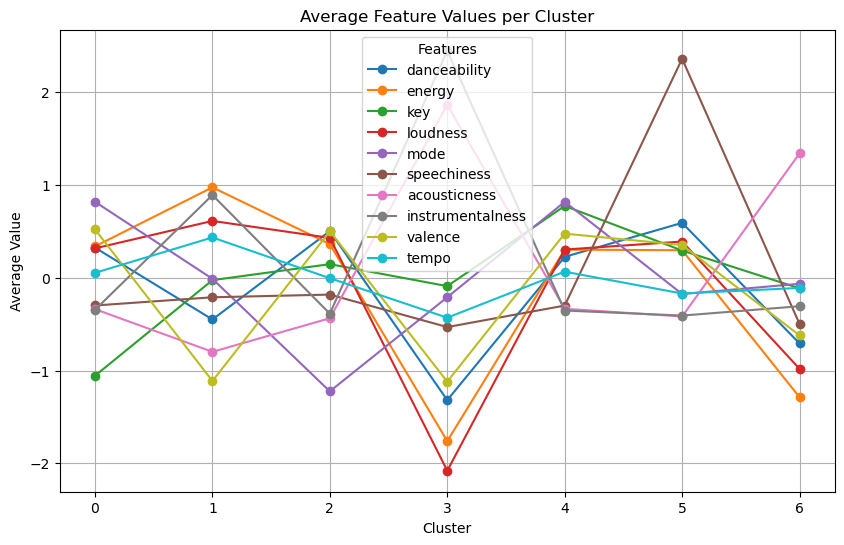

In [524]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for feature in audio_features:
    plt.plot(cluster_means.index, cluster_means[feature], marker='o', label=feature)

# Diagramm beschriften
plt.title('Average Feature Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.legend(title='Features')
plt.grid(True)
plt.show()

In [530]:
feature_variances = cluster_means.var()
print("Feature Variance:")
print(feature_variances.sort_values())     #dropping tempo

Feature Variance:
tempo               0.069604
key                 0.306789
mode                0.485453
danceability        0.516456
valence             0.600442
energy              1.006258
loudness            1.006573
speechiness         1.055014
acousticness        1.062875
instrumentalness    1.181522
dtype: float64


<h3>Programm</h3>

In [434]:
# define get audio features function

def get_audio_features(user_input):
    try:
        search_result = sp.search(q=user_input, limit=1)
        if not search_result['tracks']['items']:
            print("Song not found. Please check your input.")
            return None
        track = search_result['tracks']['items'][0]
        track_id = track['id']
        track_name = track['name']
        artist_name = track['artists'][0]['name']
        print(f"Found song: '{track_name}' von {artist_name}")
        audio_features = sp.audio_features([track_id])[0]
        if audio_features:
            return audio_features
        else:
            print("No audio features found.")
            return None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [438]:
# define get id function

def get_spotify_id(song_name, artist_name):
    try:
        results = sp.search(q=f"{song_name} {artist_name}", limit=1)
        track_id = results['tracks']['items'][0]['id']
        return track_id
    except IndexError:
        print(f"Track not found for {song_name} by {artist_name}.")
        return None

In [607]:
# define get af function

def get_audio_features(song_name):
    try:
        results = sp.search(q=song_name, type='track', limit=1)
        track_id = results['tracks']['items'][0]['id']
        audio_features = sp.audio_features([track_id])[0]
        return audio_features
    except Exception as e:
        print(f"Error fetching audio features: {e}")
        return None

In [442]:
# define get name & artist
def get_track_details(track_id):
    try:
        track_info = sp.track(track_id)
        return track_info['title'], track_info['artists'][0]['title']  
    except Exception as e:
        print(f"Error fetching track details: {e}")
        return None, None

In [683]:
scaler = scaler.fit(combined_df[audio_features])
model = best_kmeans

In [685]:
print("You can type 'exit' at any time to quit.")
while True:
    user_input = input("Please enter a song: ").strip()
    if user_input.lower() == "exit":
        print("Goodbye!")
        break

    best_match = None
    best_score = 0
    best_artist = None
# check similarity 
    for index, row in df.iterrows():
        title = row["Titles"]
        artist = row["Artists"]
        similarity = ratio(user_input.lower(), title.lower())
        if similarity > best_score:
            best_score = similarity
            best_match = title
            best_artist = artist

# match
    if best_score >= 0.99:
        track_id = get_spotify_id(best_match, best_artist)
        if track_id:
            print(f"Playing '{best_match}' by {best_artist}!")
            display(play_song(track_id))
    elif best_score >= 0.70:
        random_row = df.sample(1).iloc[0]
        random_song = random_row["Titles"]
        random_artist = random_row["Artists"]
        track_id = get_spotify_id(best_match, best_artist)
        if track_id:
            print(f"Did you mean '{best_match}' by {best_artist}? Playing it now!")
            display(play_song(track_id))
# recommand random song from hot list
        random_row = df.sample(1).iloc[0]
        print(f"Here's another recommendation: '{random_row['Titles']}' by {random_row['Artists']}.")
        track_id = get_spotify_id(random_row["Titles"], random_row["Artists"])
        display(play_song(track_id))
    else:
        print("Song not found in hot list. Checking alternatives...")
        user_audio_features = get_audio_features(user_input)                          
        if user_audio_features:
            imp_features = ['danceability', 'energy', 'key','loudness',
                            'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                            'valence']
            selected_features = {key: user_audio_features[key] for key in imp_features}
            input_df = pd.DataFrame([selected_features], columns=imp_features)
            scaled_ft = scaler.transform(input_df) 
            cluster = best_kmeans.predict(scaled_ft)[0]
            print(f"Song is in cluster {cluster}")

            random_song = combined_df[combined_df['KMeans_Cluster'] == cluster].sample(1).iloc[0]
            track_id = random_song['id']  
            track_title, artist_name = get_track_details(track_id)
            print(f"Recommended Song from Cluster {cluster}: '{track_title}' by {artist_name}")
            display(play_song(track_id))
        else:
            print("Could not fetch audio features for the input song.")

    # continue?
    user_choice = input("Do you want to search for another song? (anything to continue, exit to quit): ").strip().lower()
    if user_choice == "exit":
        print("Goodbye!")
        break

You can type 'exit' at any time to quit.


Please enter a song:  in da club


Song not found in hot list. Checking alternatives...
Song is in cluster 4
Recommended Song from Cluster 4: 'Rompe' by Daddy Yankee


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Do you want to search for another song? (anything to continue, exit to quit):  exit


Goodbye!


In [693]:
scaled_ft

array([[ 8.99000000e-01,  7.13000000e-01,  6.00000000e+00,
        -2.75200000e+00,  4.36032095e-17,  3.66000000e-01,
         2.55000000e-01,  0.00000000e+00,  7.77000000e-01]])

In [691]:
combined_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,KMeans_Cluster
0,0.011468,0.447217,1.097076,0.528670,0.81686,0.212034,-0.854561,-0.455489,0.1450,-0.792495,-0.381255,audio_features,76FZM38RC8XaAjJ77CVTNe,spotify:track:76FZM38RC8XaAjJ77CVTNe,https://api.spotify.com/v1/tracks/76FZM38RC8Xa...,https://api.spotify.com/v1/audio-analysis/76FZ...,244453,4,4
1,0.608399,0.905214,0.537032,0.952037,-1.22420,-0.282999,-0.806791,-0.455496,0.1080,-0.470707,0.278579,audio_features,5yDL13y5giogKs2fSNf7sj,spotify:track:5yDL13y5giogKs2fSNf7sj,https://api.spotify.com/v1/tracks/5yDL13y5giog...,https://api.spotify.com/v1/audio-analysis/5yDL...,197936,4,2
2,0.156179,-0.136044,0.257010,0.492964,0.81686,-0.428868,-0.894298,-0.455496,0.1650,-0.859207,0.453626,audio_features,5jrdCoLpJSvHHorevXBATy,spotify:track:5jrdCoLpJSvHHorevXBATy,https://api.spotify.com/v1/tracks/5jrdCoLpJSvH...,https://api.spotify.com/v1/audio-analysis/5jrd...,215672,4,4
3,0.403393,0.447217,1.097076,0.810030,0.81686,-0.702227,-0.889795,-0.455496,0.0756,-0.439314,0.733411,audio_features,2hns6Dv29Yrg68AVTJiAyA,spotify:track:2hns6Dv29Yrg68AVTJiAyA,https://api.spotify.com/v1/tracks/2hns6Dv29Yrg...,https://api.spotify.com/v1/audio-analysis/2hns...,208493,4,4
4,0.765169,-0.374829,0.817054,0.599877,0.81686,-0.628719,0.355813,-0.455496,0.1110,0.349458,-0.826518,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,-1.375341,0.368927,1.657119,0.003695,0.81686,-0.587370,-0.420067,-0.455487,0.3120,0.773276,-0.115373,audio_features,0mwr3py9MZIOdvOrI31h6r,spotify:track:0mwr3py9MZIOdvOrI31h6r,https://api.spotify.com/v1/tracks/0mwr3py9MZIO...,https://api.spotify.com/v1/audio-analysis/0mwr...,166520,4,4
1870,-0.416634,-1.200789,-0.023011,-0.789787,0.81686,-0.676959,1.883234,-0.449283,0.1200,-1.055419,-1.050346,audio_features,3YdKJzcoMZMacISlpY4QoP,spotify:track:3YdKJzcoMZMacISlpY4QoP,https://api.spotify.com/v1/tracks/3YdKJzcoMZMa...,https://api.spotify.com/v1/audio-analysis/3YdK...,202773,3,6
1871,-0.175450,-0.382658,-0.863077,-0.282154,-1.22420,1.475462,1.460303,-0.455496,0.2190,0.926321,1.095640,audio_features,0QoV9nLBwYEU1bA6m61h4F,spotify:track:0QoV9nLBwYEU1bA6m61h4F,https://api.spotify.com/v1/tracks/0QoV9nLBwYEU...,https://api.spotify.com/v1/audio-analysis/0QoV...,149560,4,5
1872,-1.146216,0.090997,1.377097,-0.581878,0.81686,3.416545,1.484644,-0.455496,0.3600,-0.125375,2.869307,audio_features,4rc5ZzvU4Ke8Yy2A2wRaIl,spotify:track:4rc5ZzvU4Ke8Yy2A2wRaIl,https://api.spotify.com/v1/tracks/4rc5ZzvU4Ke8...,https://api.spotify.com/v1/audio-analysis/4rc5...,142453,4,5


In [597]:
combined_df['KMeans_Cluster'].value_counts()

KMeans_Cluster
2    359
4    339
0    310
6    282
5    222
1    219
3    143
Name: count, dtype: int64

In [ ]:
# 1: techno, 2: hip hop/rap/pop 3: classic,jazz 4. happy 5.reagge, 6. chillout,blues

In [655]:
# checking cluster

desired_cluster = 6
songs_in_cluster = combined_df[combined_df['KMeans_Cluster'] == desired_cluster]
if not songs_in_cluster.empty:
    random_song = songs_in_cluster.sample(1).iloc[0]
    track_id = random_song['id'] 
    song_name = random_song.get('name', 'Unknown Song')
    artist_name = random_song.get('artist', 'Unknown Artist')
    print(f"Playing random song from Cluster {desired_cluster}: '{song_name}' by {artist_name}")
    display(play_song(track_id))
else:
    print(f"No songs found in Cluster {desired_cluster}.")

Playing random song from Cluster 6: 'Unknown Song' by Unknown Artist


In [689]:
# sieht so aus, als wird user inpu nicht richtig skaliert 
scaler

StandardScaler()